# Perceptron

The perceptron algorithm finds the optimal weights for a hyperplane to separate two classes, which is also known as binary classification.

Import the libraries

In [1]:
import numpy as np

# %matplotlib ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from celluloid import Camera
import scienceplots
from IPython.display import Image

np.random.seed(0)
plt.style.use(["science", "no-latex"])


## Hyperplane
A hyperplane is a flat subspace that is one less dimension than the current space. It can be used to linearly separate a dataset. The equation of a hyperplane is defined by the vector normal to the hyperplane $\vec{w}$

$
\begin{align*}
\vec{w} \cdot \vec{x} = w_1 x_1 + ... + w_n x_n = 0
\end{align*}
$

In our case, the $\vec{x}$ is the x, y, z coordinate.

$
\begin{align*}
\vec{w} \cdot \vec{x} &= 0 \\
&= w_1 x + w_2 y + w_3 z
\end{align*}
$

Since we want to perform binary classification using the side a point is on relative from the hyperplane, the z value can be our predicted label

$
\begin{align*}
z = -(w_1 x + w_2 y) / w_3
\end{align*}
$

Text(0.5, 0.92, 'Hyperplane')

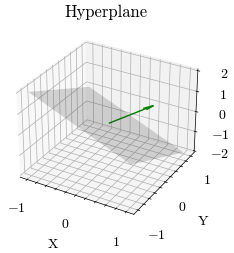

In [2]:
def generate_dataset(dims, normal_vector):
    # create 3D grid of points
    points = np.linspace(-1, 1, dims)
    X, Y, Z = np.meshgrid(points, points, points)

    # features are the x, y, z coordinates
    features = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))

    # labels are the side each point is on the hyperplane
    distances = np.dot(features, normal_vector)
    labels = np.where(distances >= 0, 1, -1)
    return X, Y, Z, features, labels


def generate_hyperplane(scaling, normal_vector):
    # create 2D points
    points = np.linspace(-1, 1, scaling)
    xx, yy = np.meshgrid(points, points)

    # the z value is the defined by the hyperplane
    zz = -(normal_vector[0] * xx + normal_vector[1] * yy) / normal_vector[2]
    return xx, yy, zz


# normalized normal vector
target_normal_vector = np.array([1.0, 1.0, 1.0])
target_normal_vector = target_normal_vector / np.linalg.norm(target_normal_vector)

scaling = 5
X, Y, Z, features, labels = generate_dataset(scaling, target_normal_vector)

xx, yy, zz = generate_hyperplane(scaling, target_normal_vector)

# visualize the hyperplane
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# plot the hyperplane defined by the normal vector
ax.plot_surface(xx, yy, zz, alpha=0.2, color="gray")
ax.quiver(
    0,
    0,
    0,
    target_normal_vector[0],
    target_normal_vector[1],
    target_normal_vector[2],
    color="green",
    length=1,
    arrow_length_ratio=0.2,
)

# plot the points
# ax.scatter(features[:,0], features[:,1], features[:,2], marker='o', alpha=0.1)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Hyperplane")

## Loss Function
Loss functions are used to quantify the error of a prediction.

### Hinge Loss
The perceptron uses the hinge loss function, which returns 0 for correct predictions and 1 for incorrect predictions. 

$
\begin{align*}
L(\vec{w}, b) = max(0, -y(\vec{w} \cdot \vec{x} + b)
\end{align*}
$

In [3]:
def hinge_loss(w, x, b, y):
    return max(0.0, -y * (np.dot(w, x) + b))

### Hinge Loss Gradient
In order to run gradient descent to update our parameters, the gradients with respect to W and b must be calculated

Loss function with respect to $b$

$
\frac{\partial L}{\partial b} = \begin{cases}
0 & -y(\vec{w} \cdot \vec{x} + b) > 1 \\
-y & \text{otherwise}
\end{cases}
$

In [4]:
def hinge_loss_db(w, x, b, y):
    if y * (np.dot(w, x) + b) <= 0.0:
        return -y
    return 0

Loss function with respect to $\vec{w}$

$
\nabla_{W} [L(\vec{w}, b)] = \begin{cases}
0 & -y(\vec{w} \cdot \vec{x} + b) > 1 \\
-y x & \text{otherwise}
\end{cases}
$

In [5]:
def hinge_loss_dw(w, x, b, y):
    if y * (np.dot(w, x) + b) <= 0.0:
        return -y * x
    return np.zeros_like(x)

In [6]:
def create_plots():
    fig, ax = plt.subplots(1, 3, figsize=(16 / 9.0 * 4, 4 * 1), layout="constrained")
    fig.suptitle("Perceptron")

    ax[0].set_xlabel("Epoch", fontweight="normal")
    ax[0].set_ylabel("Error", fontweight="normal")
    ax[0].set_title("Hinge Loss")

    ax[1].axis("off")
    ax[2].axis("off")

    ax[2] = fig.add_subplot(1, 2, 2, projection="3d")
    ax[2].set_xlabel("X")
    ax[2].set_ylabel("Y")
    ax[2].set_zlabel("Z")
    ax[2].set_title("Hyperplane Decision Boundary")
    ax[2].view_init(20, -35)
    ax[2].set_xlim(-1, 1)
    ax[2].set_ylim(-1, 1)
    ax[2].set_zlim(-1, 1)

    camera = Camera(fig)
    return ax[0], ax[2], camera

## Training the model

Gradient Descent will be used to update the weights and bias.

$
\begin{align*}
\vec{w} &= \vec{w} - \eta \nabla_{W} [L(\vec{w}, b)] \\
b &= b - \eta \frac{\partial}{\partial b} [L(\vec{w}, b)] 
\end{align*}
$

In [7]:
def gradient_descent(weights, x, bias, y, learning_rate):
    weights = weights - learning_rate * hinge_loss_dw(weights, x, bias, y)
    bias = bias - learning_rate * hinge_loss_db(weights, x, bias, y)

    return weights, bias

In [8]:
def fit(
    weights,
    bias,
    target_normal_vector,
    features,
    labels,
    X,
    Y,
    Z,
    scaling,
    epochs,
    learning_rate,
    optimizer,
    output_filename,
):
    err_idx = np.arange(1, epochs + 1)
    errors = np.full(epochs, -1)
    ax0, ax1, camera = create_plots()

    for idx in range(epochs):
        error = 0
        predictions = np.array([])

        for x, y in zip(features, labels):
            # Forward Propagation
            output = np.dot(weights, x) + bias

            predictions = np.append(predictions, output)

            # Store Error
            error += hinge_loss(weights, x, bias, y)

            # Gradient Descent
            weights, bias = optimizer(weights, x, bias, y, learning_rate)

        error /= len(X)
        weights = weights / np.linalg.norm(weights)

        if (
            idx < 5
            or (idx < 15 and idx % 2 == 0)
            or (idx <= 50 and idx % 10 == 0)
            or (idx <= 1000 and idx % 20 == 0)
            or idx % 250 == 0
        ):

            print(f"epoch: {idx}, MSE: {error}")

            # Plot MSE
            errors[idx] = error
            visible_err = errors != -1
            ax0.plot(
                err_idx[visible_err][: idx + 1],
                errors[visible_err][: idx + 1],
                color="red",
                alpha=0.2,
            )

            # Ground truth
            xx_target, yy_target, zz_target = generate_hyperplane(
                scaling, target_normal_vector
            )
            ground_truth_legend = ax1.plot_surface(
                xx_target,
                yy_target,
                zz_target,
                color="red",
                alpha=0.2,
                label="Ground Truth",
            )
            ax1.quiver(
                0,
                0,
                0,
                target_normal_vector[0],
                target_normal_vector[1],
                target_normal_vector[2],
                color="red",
                length=1,
                arrow_length_ratio=0.1,
            )

            # Perceptron Predictions
            colors = colors = ["green" if d >= 0 else "orange" for d in predictions]
            ax1.scatter(
                features[:, 0],
                features[:, 1],
                features[:, 2],
                c=colors,
                marker="o",
                alpha=0.2,
            )

            xx, yy, zz = generate_hyperplane(scaling, weights)
            predictions_legend = ax1.plot_surface(
                xx,
                yy,
                zz,
                color="blue",
                alpha=0.2,
                label="Prediction",
            )
            ax1.quiver(
                0,
                0,
                0,
                weights[0],
                weights[1],
                weights[2],
                color="blue",
                length=1,
                arrow_length_ratio=0.1,
            )

            # Legend
            ax1.legend(
                (ground_truth_legend, predictions_legend),
                ("Ground Truth", "Predictions"),
                loc="upper left",
            )

            camera.snap()

    animation = camera.animate()
    animation.save(output_filename, writer="pillow")
    plt.show()

In [9]:
weights = np.array([1.0, -1.0, -1.0])
weights = weights / np.linalg.norm(weights)

bias = 0

epoch: 0, MSE: 9.314269414709884
epoch: 1, MSE: 9.227024830601328
epoch: 2, MSE: 9.145087443313994
epoch: 3, MSE: 9.054781136556876
epoch: 4, MSE: 8.960407022428585
epoch: 6, MSE: 8.758853058777225
epoch: 8, MSE: 8.53921460232333
epoch: 10, MSE: 8.30137439690734
epoch: 12, MSE: 8.08268967439665
epoch: 14, MSE: 7.848010649913293
epoch: 20, MSE: 7.2399656649458395
epoch: 30, MSE: 6.264254344109915
epoch: 40, MSE: 5.307156953825979
epoch: 50, MSE: 4.404348110031334
epoch: 60, MSE: 3.5837443020613877
epoch: 80, MSE: 2.0340687540122775
epoch: 100, MSE: 0.9393759997635168
epoch: 120, MSE: 0.35445883826326263
epoch: 140, MSE: 0.12744345824321743
epoch: 160, MSE: 0.018715050957433404
epoch: 180, MSE: 0.0
epoch: 200, MSE: 0.0


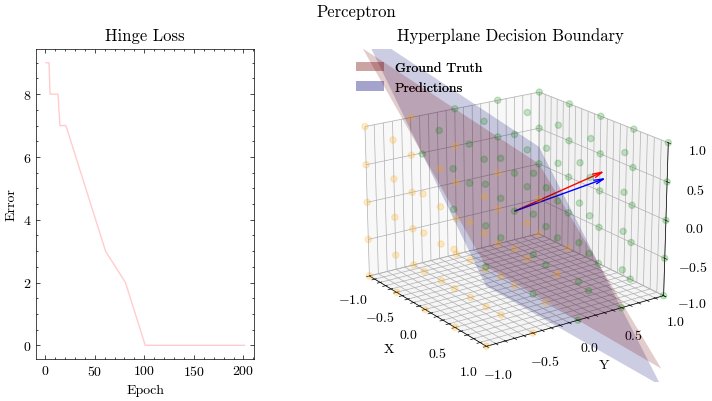

In [10]:
epochs = 201
learning_rate = 0.0005

output_filename = "perceptron.gif"
fit(
    weights,
    bias,
    target_normal_vector,
    features,
    labels,
    X,
    Y,
    Z,
    scaling,
    epochs,
    learning_rate,
    gradient_descent,
    output_filename,
)

## Output GIF

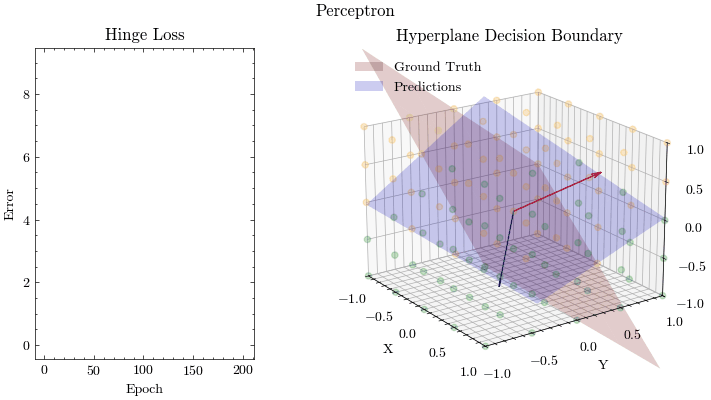

In [11]:
Image(filename=output_filename)